# Output Plots from Noisy GA Optimization for Euler Beam

## Extracting Data

We want to extract data so that we have the following rows:

Given a file source we want the following two tables:

1. Final Gen Data

From Data:
- Damaged element (e=...)(E_e = Γ*E_0)
- Damage factor (Γ)
- Noise stddev factor (σ_noise)
- Best solution (E_best)
- Number of Generations (N_gen)
- Fitness (J)

Calculated:
- RMSE
- Frequencies
- Mode Shape
- Frequency fitness
- Mode shape fitness


In [67]:
import json
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add src directory to Python path
src_path = str(Path.cwd().parent)  # if notebook is in src/
if src_path not in sys.path:
    sys.path.append(src_path)

# Constants
E_0 = 26e9  # Base Young's modulus

# Read JSONL file
data_list = []
with open(r"C:\Users\attri\OneDrive\Documents\Academic Work Nadia\MEng Y5\CEE Thesis\SEM2\SHM\results\noisy_ga_optimization_updated\noisy_runs.jsonl", 'r') as file:
    for line in file:
        data = json.loads(line)
        
        # Create target solution array
        target_solution = [E_0] * 10  # Initialize with base E_0
        damaged_element = data['scenario'][0]['element']
        damage_factor = data['scenario'][0]['factor']
        target_solution[damaged_element] = E_0 * (1 - damage_factor)  # Apply damage
        
        # Extract required information
        row = {
            'damaged_element': damaged_element + 1,  # Convert to 1-based indexing
            'damage_factor': 1 - damage_factor,  # Convert to Γ (intact ratio)
            'noise_stddev': data['fitness_parameters']['noise_stddev_factor'],
            'generations': data['generations_completed'],
            'fitness': data['best_fitness']
        }
        
        # Add identified solution elements (E_identified)
        for i, E in enumerate(data['best_solution'], 1):
            row[f'E{i}_identified'] = E
            
        # Add target solution elements (E_target)
        for i, E in enumerate(target_solution, 1):
            row[f'E{i}_target'] = E
            
        # Add normalized solutions (E/E_0)
        for i in range(1, 11):
            row[f'E{i}_identified_ratio'] = row[f'E{i}_identified'] / E_0
            row[f'E{i}_target_ratio'] = row[f'E{i}_target'] / E_0
        
        data_list.append(row)

# Create DataFrame
df = pd.DataFrame(data_list)

# Reorder columns
cols = ['damaged_element', 'damage_factor', 'noise_stddev', 'generations', 'fitness']
E_cols = []
for i in range(1, 11):
    E_cols.extend([f'E{i}_target', f'E{i}_identified', f'E{i}_target_ratio', f'E{i}_identified_ratio'])
df = df[cols + E_cols]

# Sort DataFrame
df = df.sort_values(['damaged_element', 'damage_factor', 'noise_stddev'])

print("DataFrame columns:")
print(df.columns.tolist())
print("\nDataFrame shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Save to CSV if needed
# df.to_csv("analysis_results.csv", index=False)

DataFrame columns:
['damaged_element', 'damage_factor', 'noise_stddev', 'generations', 'fitness', 'E1_target', 'E1_identified', 'E1_target_ratio', 'E1_identified_ratio', 'E2_target', 'E2_identified', 'E2_target_ratio', 'E2_identified_ratio', 'E3_target', 'E3_identified', 'E3_target_ratio', 'E3_identified_ratio', 'E4_target', 'E4_identified', 'E4_target_ratio', 'E4_identified_ratio', 'E5_target', 'E5_identified', 'E5_target_ratio', 'E5_identified_ratio', 'E6_target', 'E6_identified', 'E6_target_ratio', 'E6_identified_ratio', 'E7_target', 'E7_identified', 'E7_target_ratio', 'E7_identified_ratio', 'E8_target', 'E8_identified', 'E8_target_ratio', 'E8_identified_ratio', 'E9_target', 'E9_identified', 'E9_target_ratio', 'E9_identified_ratio', 'E10_target', 'E10_identified', 'E10_target_ratio', 'E10_identified_ratio']

DataFrame shape: (24, 45)

First few rows:
    damaged_element  damage_factor  noise_stddev  generations   fitness  \
2                 1            0.8          0.00          2

In [68]:

# Calculate RMSE for each case
def calculate_rmse(row):
    # Get target and identified ratios for all elements
    target_ratios = [row[f'E{i}_target_ratio'] for i in range(1, 11)]
    identified_ratios = [row[f'E{i}_identified_ratio'] for i in range(1, 11)]
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean([(t - i)**2 for t, i in zip(target_ratios, identified_ratios)]))
    return rmse

# Add RMSE column to DataFrame
df['rmse'] = df.apply(calculate_rmse, axis=1)

# Sort and display results
results = df[['damaged_element', 'damage_factor', 'noise_stddev', 'rmse']].sort_values('rmse')
print("RMSE Statistics:")
print("\nTop 5 best identifications (lowest RMSE):")
print(results.head())
print("\nWorst 5 identifications (highest RMSE):")
print(results.tail())
print("\nRMSE summary statistics:")
print(df.groupby(['noise_stddev'])['rmse'].describe())

RMSE Statistics:

Top 5 best identifications (lowest RMSE):
   damaged_element  damage_factor  noise_stddev      rmse
0                1           0.95           0.0  0.008580
1                1           0.90           0.0  0.030691
2                1           0.80           0.0  0.035980
4                5           0.90           0.0  0.052269
5                5           0.80           0.0  0.053611

Worst 5 identifications (highest RMSE):
    damaged_element  damage_factor  noise_stddev      rmse
20                1            0.8          0.20  0.122844
14                1            0.8          0.10  0.132481
10                5            0.9          0.05  0.133558
8                 1            0.8          0.05  0.143856
23                5            0.8          0.20  0.154967

RMSE summary statistics:
              count      mean       std       min       25%       50%  \
noise_stddev                                                            
0.00            6.0  0.04

In [69]:
from beam.beam import Beam
import numpy as np

# Create base beam configuration
base_config = {
    'geometry': {
        'width': 0.3,
        'height': 0.1,
        'length': 2.0
    },
    'mesh': {
        'n_p': 10,
        'n_e': 100,
        'n_mp': 21
    },
    'material': {
        'E': 26e9,
        'rho': 2300.0,
        'nu': 0.3
    }
}

# Function to calculate modal properties for a given E vector
def get_modal_properties(E_vector, n_modes=4):
    beam = Beam(config=base_config, E_vector=E_vector)
    freqs, modes = beam.get_modal_properties(n_eigen=n_modes)
    return freqs, modes

# Add modal properties to DataFrame
modal_data = []
for _, row in df.iterrows():
    # Get target E vector
    target_E = [row[f'E{i}_target'] for i in range(1, 11)]
    identified_E = [row[f'E{i}_identified'] for i in range(1, 11)]
    
    # Calculate modal properties
    target_freqs, target_modes = get_modal_properties(target_E)
    identified_freqs, identified_modes = get_modal_properties(identified_E)
    
    # Create dictionary with modal properties
    modal_dict = {
        'target_freq_1': target_freqs[0],
        'target_freq_2': target_freqs[1],
        'target_freq_3': target_freqs[2],
        'target_freq_4': target_freqs[3],
        'identified_freq_1': identified_freqs[0],
        'identified_freq_2': identified_freqs[1],
        'identified_freq_3': identified_freqs[2],
        'identified_freq_4': identified_freqs[3]
    }
    
    # Add mode shapes
    for i in range(4):
        modal_dict[f'target_mode_{i+1}'] = target_modes[i, :]
        modal_dict[f'identified_mode_{i+1}'] = identified_modes[i, :]
    
    modal_data.append(modal_dict)

# Convert to DataFrame and join with existing DataFrame
modal_df = pd.DataFrame(modal_data)
df = pd.concat([df, modal_df], axis=1)


# Calculate frequency differences (as percentage)
for i in range(1, 5):
    df[f'freq_{i}_diff_pct'] = (df[f'identified_freq_{i}'] - df[f'target_freq_{i}']) / df[f'target_freq_{i}'] * 100

# Calculate MAC values for mode shapes
def calculate_mac(mode1, mode2):
    return np.abs(np.dot(mode1, mode2))**2 / (np.dot(mode1, mode1) * np.dot(mode2, mode2))

for i in range(1, 5):
    df[f'mac_{i}'] = df.apply(lambda row: calculate_mac(
        row[f'target_mode_{i}'], 
        row[f'identified_mode_{i}']), axis=1)

print("Added columns:")
print("\nFrequencies:", [col for col in df.columns if 'freq' in col])
print("\nMAC values:", [col for col in df.columns if 'mac' in col])
print("\nSample of results:")
print(df[['damaged_element', 'damage_factor', 'noise_stddev', 
         'freq_1_diff_pct', 'freq_2_diff_pct', 'freq_3_diff_pct',
         'mac_1', 'mac_2', 'mac_3']].head())

Added columns:

Frequencies: ['target_freq_1', 'target_freq_2', 'target_freq_3', 'target_freq_4', 'identified_freq_1', 'identified_freq_2', 'identified_freq_3', 'identified_freq_4', 'freq_1_diff_pct', 'freq_2_diff_pct', 'freq_3_diff_pct', 'freq_4_diff_pct']

MAC values: ['mac_1', 'mac_2', 'mac_3', 'mac_4']

Sample of results:
   damaged_element  damage_factor  noise_stddev  freq_1_diff_pct  \
0                1           0.95           0.0         0.008027   
1                1           0.90           0.0        -0.079251   
2                1           0.80           0.0         0.109041   
3                5           0.95           0.0        -0.000291   
4                5           0.90           0.0        -0.008088   

   freq_2_diff_pct  freq_3_diff_pct     mac_1     mac_2     mac_3  
0         0.008533        -0.000008  0.999988  0.999946  0.999924  
1         0.077328        -0.004267  0.999706  0.999158  0.999008  
2        -0.021197        -0.008379  0.999955  0.999907  0.

In [70]:
df.target_mode_3[0]

array([ 0.        ,  0.05763481,  0.10043759,  0.11986265,  0.11376609,
        0.08330073,  0.03496226, -0.02084175, -0.0720616 , -0.10762543,
       -0.11984385, -0.10607958, -0.06932114, -0.01753672,  0.03805139,
        0.08539763,  0.1142428 ,  0.11833654,  0.0967915 ,  0.05427547,
        0.        ])

=== Damage Identification Report ===

Scenario Information:
Damaged Element: 1
Damage Factor (Γ): 0.950
Noise Level (σ): 0.050

Identification Results:
Number of Generations: 200
Final Fitness: 4.814933
RMSE: 0.081842
Average Mode Shape Difference: 0.010555
Average Frequency Difference: 0.000149


c:\Users\attri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\attri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0, flags=flags)


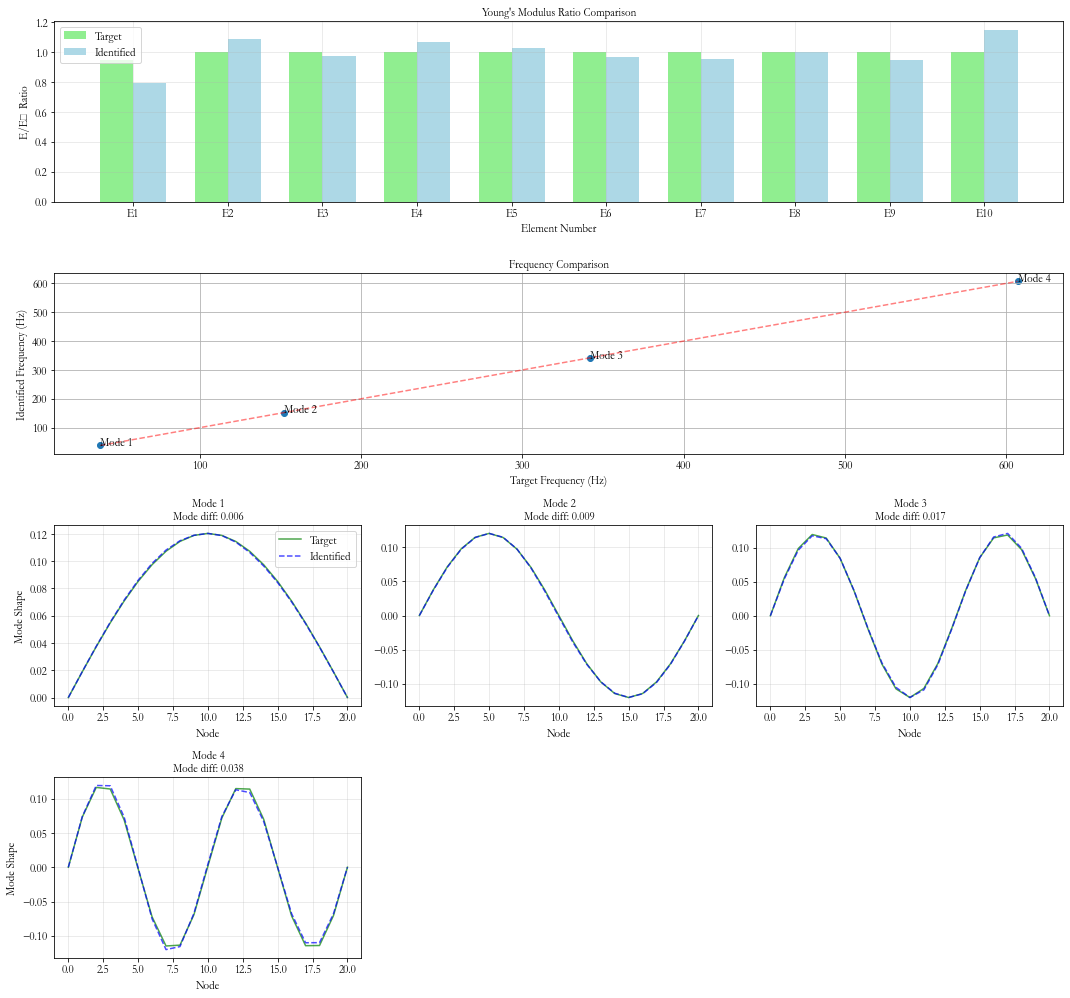

In [71]:
import matplotlib.pyplot as plt
from ga.operators.fitness import calculate_mode_diff, calculate_frequency_diff

# First add the fitness metrics to DataFrame
def add_fitness_metrics(df):
    """Add mode_diff and freq_diff metrics to DataFrame"""
    
    # Initialize new columns
    df['mode_diff_avg'] = 0.0
    df['freq_diff_avg'] = 0.0
    
    # Calculate metrics for each row
    for idx, row in df.iterrows():
        # Get target and identified mode shapes
        mode_diffs = []
        freq_diffs = []
        
        for i in range(1, 4):  # For first 3 modes
            # Mode shape differences
            target_mode = row[f'target_mode_{i}']
            identified_mode = row[f'identified_mode_{i}']
            mode_diff = calculate_mode_diff(identified_mode, target_mode)
            mode_diffs.append(mode_diff)
            
            # Frequency differences
            target_freq = row[f'target_freq_{i}']
            identified_freq = row[f'identified_freq_{i}']
            freq_diff = calculate_frequency_diff(identified_freq, target_freq)
            freq_diffs.append(freq_diff)
        
        # Store averages
        df.at[idx, 'mode_diff_avg'] = np.mean(mode_diffs)
        df.at[idx, 'freq_diff_avg'] = np.mean(freq_diffs)
    
    return df

def generate_report(df, row_idx):
    """Generate comprehensive report for a specific row in the DataFrame"""
    row = df.iloc[row_idx]
    
    # Determine number of modes from column names
    mode_cols = [col for col in df.columns if 'target_mode_' in col]
    n_modes = len(mode_cols)
    
    # Calculate number of rows needed for mode shape plots
    n_rows_modes = (n_modes + 2) // 3  # 3 plots per row, rounded up
    
    # Create figure with dynamic gridspec
    fig = plt.figure(figsize=(15, 6 + 4*n_rows_modes))
    gs = fig.add_gridspec(2 + n_rows_modes, 3)  # E ratio plot, freq plot, and mode shape rows
    
    # 1. Print Information
    print("=== Damage Identification Report ===")
    print(f"\nScenario Information:")
    print(f"Damaged Element: {row['damaged_element']}")
    print(f"Damage Factor (Γ): {row['damage_factor']:.3f}")
    print(f"Noise Level (σ): {row['noise_stddev']:.3f}")
    print(f"\nIdentification Results:")
    print(f"Number of Generations: {row['generations']}")
    print(f"Final Fitness: {row['fitness']:.6f}")
    print(f"RMSE: {row['rmse']:.6f}")
    print(f"Average Mode Shape Difference: {row['mode_diff_avg']:.6f}")
    print(f"Average Frequency Difference: {row['freq_diff_avg']:.6f}")
    
    # 2. Bar Plot comparing target and identified ratios (spans all columns)
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(10)
    width = 0.35
    
    target_ratios = [row[f'E{i}_target_ratio'] for i in range(1, 11)]
    identified_ratios = [row[f'E{i}_identified_ratio'] for i in range(1, 11)]
    
    ax1.bar(x - width/2, target_ratios, width, label='Target', color='lightgreen')
    ax1.bar(x + width/2, identified_ratios, width, label='Identified', color='lightblue')
    ax1.set_xlabel('Element Number')
    ax1.set_ylabel('E/E₀ Ratio')
    ax1.set_title('Young\'s Modulus Ratio Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'E{i+1}' for i in range(10)])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 3. Frequency Comparison Scatter Plot
    ax2 = fig.add_subplot(gs[1, :])
    target_freqs = [row[f'target_freq_{i}'] for i in range(1, n_modes + 1)]
    identified_freqs = [row[f'identified_freq_{i}'] for i in range(1, n_modes + 1)]
    
    ax2.scatter(target_freqs, identified_freqs)
    for i, (tf, idf) in enumerate(zip(target_freqs, identified_freqs), 1):
        ax2.annotate(f'Mode {i}', (tf, idf))
    ax2.plot([min(target_freqs), max(target_freqs)], 
             [min(target_freqs), max(target_freqs)], 'r--', alpha=0.5)
    ax2.set_xlabel('Target Frequency (Hz)')
    ax2.set_ylabel('Identified Frequency (Hz)')
    ax2.set_title('Frequency Comparison')
    ax2.grid(True)
    
    # 4. Mode Shape Comparisons (in rows of 3)
    for i in range(n_modes):
        row_idx = 2 + (i // 3)  # Start from row 2, 3 plots per row
        col_idx = i % 3         # Columns 0, 1, 2
        
        ax = fig.add_subplot(gs[row_idx, col_idx])
        target_mode = row[f'target_mode_{i+1}']
        identified_mode = row[f'identified_mode_{i+1}']
        
        ax.plot(target_mode, 'g-', label='Target', alpha=0.7)
        ax.plot(identified_mode, 'b--', label='Identified', alpha=0.7)
        mode_diff = calculate_mode_diff(identified_mode, target_mode)
        
        ax.set_title(f'Mode {i+1}\nMode diff: {mode_diff:.3f}')
        ax.set_xlabel('Node')
        ax.set_ylabel('Mode Shape' if col_idx == 0 else '')
        if i == 0:
            ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
# Example usage:
df = add_fitness_metrics(df)  # Add the fitness metrics first
generate_report(df, 6)  # Generate report for first row

   damaged_element  damage_factor  noise_stddev  generations   fitness  \
2                1            0.8           0.0          200  6.652615   

      E1_target  E1_identified  E1_target_ratio  E1_identified_ratio  \
2  2.080000e+10   2.171433e+10              0.8             0.835166   

      E2_target  ...  freq_1_diff_pct  freq_2_diff_pct  freq_3_diff_pct  \
2  2.600000e+10  ...         0.109041        -0.021197        -0.008379   

   freq_4_diff_pct     mac_1     mac_2     mac_3     mac_4  mode_diff_avg  \
2         0.002804  0.999955  0.999907  0.999204  0.995671       0.013901   

   freq_diff_avg  
2       0.000462  

[1 rows x 72 columns]
=== Aggregate Damage Identification Report ===

Scenario Information:
Damaged Element: 1
Damage Factor (Γ): 0.800
Noise Level (σ): 0.000
Number of Runs: 1

Identification Results (mean ± std):
Number of Generations: 200.0 ± nan
Final Fitness: 6.652615 ± nan
RMSE: 0.035980 ± nan
Mode Shape Difference: 0.013901 ± nan
Frequency Difference: 

c:\Users\attri\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\attri\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\attri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\attri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0, flags=flags)


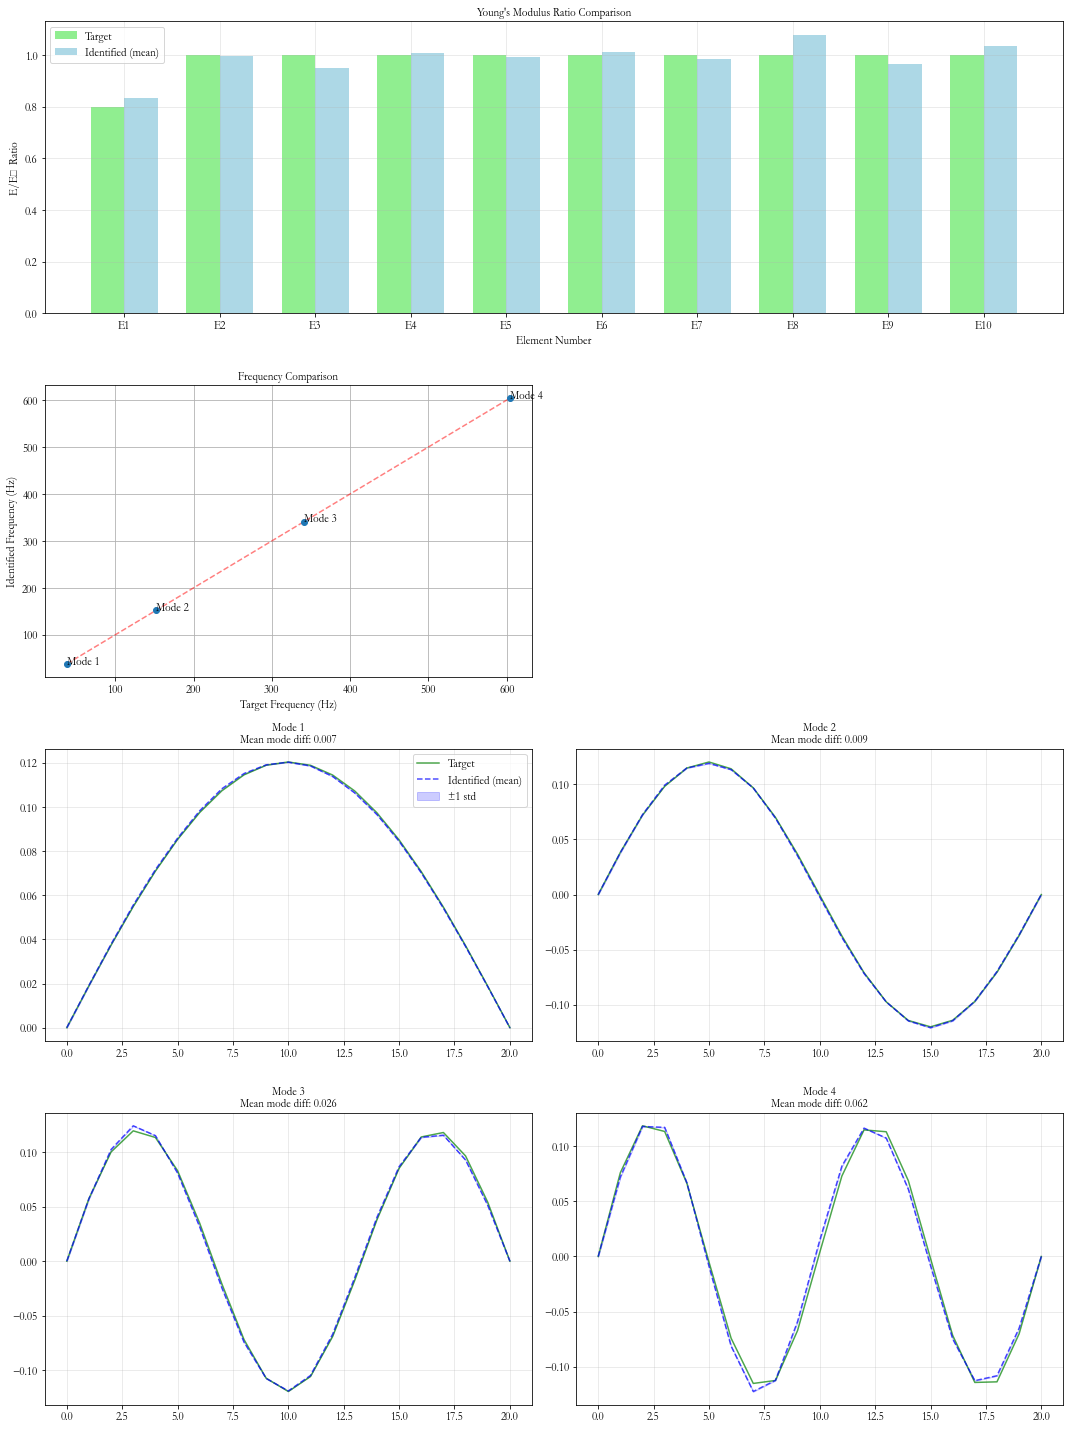

In [72]:
def generate_aggregate_report(df, damaged_element, damage_factor, noise_level):
    """Generate aggregate report for all runs with specified damage scenario"""
    
    # Filter DataFrame for the specified scenario
    mask = (df['damaged_element'] == damaged_element) & \
           (df['damage_factor'] == damage_factor) & \
           (df['noise_stddev'] == noise_level)
    scenario_df = df[mask]

    print(scenario_df.head())
    
    n_runs = len(scenario_df)
    if n_runs == 0:
        print("No data found for specified scenario")
        return
        
    # Determine number of modes
    mode_cols = [col for col in df.columns if 'target_mode_' in col]
    n_modes = len(mode_cols)
    
    n_mode_rows = (n_modes + 1) // 2  # Round up division
    total_rows = 2 + n_mode_rows  # E/E₀ plot + frequency plot + mode shape rows
    
    # Create figure with dynamic gridspec
    fig = plt.figure(figsize=(15, 5*total_rows))
    gs = fig.add_gridspec(total_rows, 2)
    
    # 1. Print Aggregate Information
    print("=== Aggregate Damage Identification Report ===")
    print(f"\nScenario Information:")
    print(f"Damaged Element: {damaged_element}")
    print(f"Damage Factor (Γ): {damage_factor:.3f}")
    print(f"Noise Level (σ): {noise_level:.3f}")
    print(f"Number of Runs: {n_runs}")
    print(f"\nIdentification Results (mean ± std):")
    print(f"Number of Generations: {scenario_df['generations'].mean():.1f} ± {scenario_df['generations'].std():.1f}")
    print(f"Final Fitness: {scenario_df['fitness'].mean():.6f} ± {scenario_df['fitness'].std():.6f}")
    print(f"RMSE: {scenario_df['rmse'].mean():.6f} ± {scenario_df['rmse'].std():.6f}")
    print(f"Mode Shape Difference: {scenario_df['mode_diff_avg'].mean():.6f} ± {scenario_df['mode_diff_avg'].std():.6f}")
    print(f"Frequency Difference: {scenario_df['freq_diff_avg'].mean():.6f} ± {scenario_df['freq_diff_avg'].std():.6f}")
    
    # 2. E/E₀ Ratio Plot with Confidence Intervals
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(10)
    width = 0.35
    
    # Get target ratios (same for all runs)
    target_ratios = [scenario_df[f'E{i}_target_ratio'].iloc[0] for i in range(1, 11)]
    
    # Calculate mean and std of identified ratios
    identified_means = [scenario_df[f'E{i}_identified_ratio'].mean() for i in range(1, 11)]
    identified_stds = [scenario_df[f'E{i}_identified_ratio'].std() for i in range(1, 11)]
    
    # Plot bars and error bars
    ax1.bar(x - width/2, target_ratios, width, label='Target', color='lightgreen')
    ax1.bar(x + width/2, identified_means, width, label='Identified (mean)', color='lightblue')
    ax1.errorbar(x + width/2, identified_means, yerr=identified_stds, fmt='none', color='blue', capsize=5)
    
    ax1.set_xlabel('Element Number')
    ax1.set_ylabel('E/E₀ Ratio')
    ax1.set_title('Young\'s Modulus Ratio Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'E{i+1}' for i in range(10)])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 3. Frequency Comparison
    ax2 = fig.add_subplot(gs[1, 0])
    target_freqs = np.array([scenario_df[f'target_freq_{i}'].iloc[0] for i in range(1, n_modes + 1)])
    identified_means = np.array([scenario_df[f'identified_freq_{i}'].mean() for i in range(1, n_modes + 1)])
    identified_stds = np.array([scenario_df[f'identified_freq_{i}'].std() for i in range(1, n_modes + 1)])
    
    ax2.errorbar(target_freqs, identified_means, yerr=identified_stds, fmt='o', capsize=5)
    for i, (tf, idm) in enumerate(zip(target_freqs, identified_means), 1):
        ax2.annotate(f'Mode {i}', (tf, idm))
    ax2.plot([target_freqs.min(), target_freqs.max()], 
             [target_freqs.min(), target_freqs.max()], 'r--', alpha=0.5)
    ax2.set_xlabel('Target Frequency (Hz)')
    ax2.set_ylabel('Identified Frequency (Hz)')
    ax2.set_title('Frequency Comparison')
    ax2.grid(True)
    
    # 4.  Mode Shape Comparisons (2 per row)
    for i in range(n_modes):
        row = 2 + (i // 2)  # Start from row 2, 2 plots per row
        col = i % 2         # Alternate between columns 0 and 1
        
        ax = fig.add_subplot(gs[row, col])
        target_mode = scenario_df[f'target_mode_{i+1}'].iloc[0]
        
        # Calculate mean and std of identified mode shapes
        identified_modes = np.vstack(scenario_df[f'identified_mode_{i+1}'])
        mode_mean = identified_modes.mean(axis=0)
        mode_std = identified_modes.std(axis=0)
        
        # Plot with confidence interval
        x_points = np.arange(len(target_mode))
        ax.plot(x_points, target_mode, 'g-', label='Target', alpha=0.7)
        ax.plot(x_points, mode_mean, 'b--', label='Identified (mean)', alpha=0.7)
        ax.fill_between(x_points, mode_mean - mode_std, mode_mean + mode_std, 
                       color='blue', alpha=0.2, label='±1 std')
        
        mode_diff = calculate_mode_diff(mode_mean, target_mode)
        ax.set_title(f'Mode {i+1}\nMean mode diff: {mode_diff:.3f}')
        if i == 0:
            ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
generate_aggregate_report(df, damaged_element=1, damage_factor=0.8, noise_level=0.0)

In [73]:
df.columns

Index(['damaged_element', 'damage_factor', 'noise_stddev', 'generations',
       'fitness', 'E1_target', 'E1_identified', 'E1_target_ratio',
       'E1_identified_ratio', 'E2_target', 'E2_identified', 'E2_target_ratio',
       'E2_identified_ratio', 'E3_target', 'E3_identified', 'E3_target_ratio',
       'E3_identified_ratio', 'E4_target', 'E4_identified', 'E4_target_ratio',
       'E4_identified_ratio', 'E5_target', 'E5_identified', 'E5_target_ratio',
       'E5_identified_ratio', 'E6_target', 'E6_identified', 'E6_target_ratio',
       'E6_identified_ratio', 'E7_target', 'E7_identified', 'E7_target_ratio',
       'E7_identified_ratio', 'E8_target', 'E8_identified', 'E8_target_ratio',
       'E8_identified_ratio', 'E9_target', 'E9_identified', 'E9_target_ratio',
       'E9_identified_ratio', 'E10_target', 'E10_identified',
       'E10_target_ratio', 'E10_identified_ratio', 'rmse', 'target_freq_1',
       'target_freq_2', 'target_freq_3', 'target_freq_4', 'identified_freq_1',
       'id

In [74]:
# Filter DataFrame for the specified scenario
mask = (df['damaged_element'] == 5) & \
           (df['damage_factor'] == 0.8) & \
           (df['noise_stddev'] == 5)
df[mask]

,damaged_element,damage_factor,noise_stddev,generations,fitness,E1_target,E1_identified,E1_target_ratio,E1_identified_ratio,E2_target,...,freq_1_diff_pct,freq_2_diff_pct,freq_3_diff_pct,freq_4_diff_pct,mac_1,mac_2,mac_3,mac_4,mode_diff_avg,freq_diff_avg


=== Noisy Beam Comparison ===
Noise Level (σ): 0.200
Damaged Element: 5
Damage Factor (Γ): 0.900


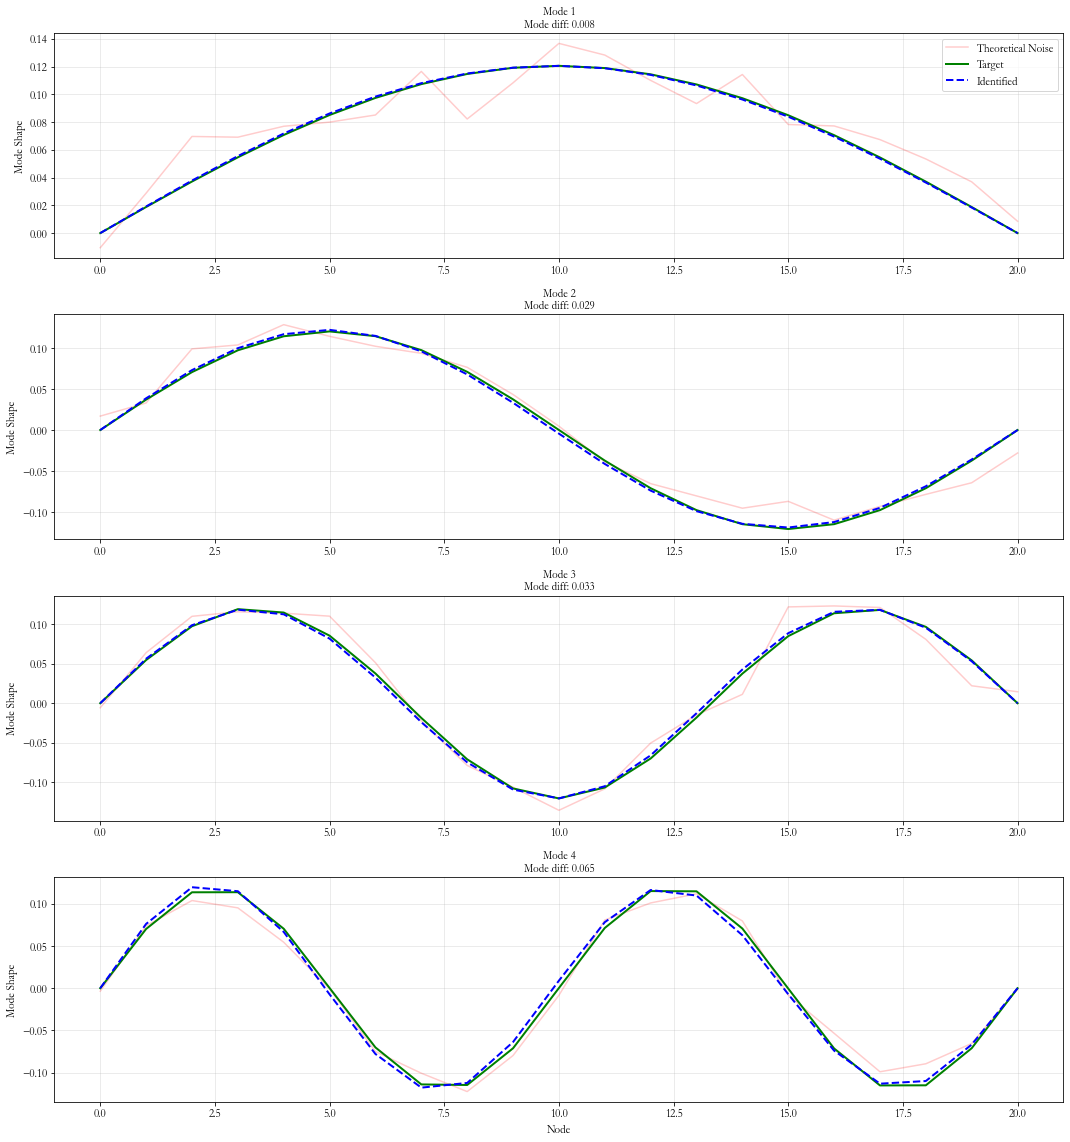

In [78]:
def generate_noisy_comparison(df, row_idx, n_samples=1):
    """Generate and compare theoretical noisy beam with actual data"""
    row = df.iloc[row_idx]
    noise_level = row['noise_stddev']
    n_modes = len([col for col in df.columns if 'target_mode_' in col])
    
    fig = plt.figure(figsize=(15, 4*n_modes))
    gs = fig.add_gridspec(n_modes, 1)
    
    # Print information
    print("=== Noisy Beam Comparison ===")
    print(f"Noise Level (σ): {noise_level:.3f}")
    print(f"Damaged Element: {row['damaged_element']}")
    print(f"Damage Factor (Γ): {row['damage_factor']:.3f}")
    
    # Generate and plot noisy modes
    for i in range(n_modes):
        ax = fig.add_subplot(gs[i])
        target_mode = row[f'target_mode_{i+1}']
        identified_mode = row[f'identified_mode_{i+1}']
        
        # Calculate mean amplitude for noise scaling
        mean_amplitude = np.mean(np.abs(target_mode))
        noise_std = noise_level * mean_amplitude
        
        # Generate noisy samples
        x = np.arange(len(target_mode))
        noisy_samples = []
        for _ in range(n_samples):
            noise = np.random.normal(0, noise_std, size=target_mode.shape)
            noisy_mode = target_mode + noise
            noisy_samples.append(noisy_mode)
            ax.plot(x, noisy_mode, 'r-', alpha=0.2, label='Theoretical Noise' if _ == 0 else None)
        
        # Plot original and identified
        ax.plot(x, target_mode, 'g-', label='Target', linewidth=2)
        ax.plot(x, identified_mode, 'b--', label='Identified', linewidth=2)
        
        # Calculate and display metrics
        mode_diff = calculate_mode_diff(identified_mode, target_mode)
        ax.set_title(f'Mode {i+1}\nMode diff: {mode_diff:.3f}')
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend()
        ax.set_xlabel('Node' if i == n_modes-1 else '')
        ax.set_ylabel('Mode Shape')
    
    plt.tight_layout()
    plt.show()

# Example usage with 10 noisy samples
generate_noisy_comparison(df, row_idx=22, n_samples=1)

=== Noisy Beam Comparison ===
Noise Level (σ): 0.050
Damaged Element: 1
Damage Factor (Γ): 0.950


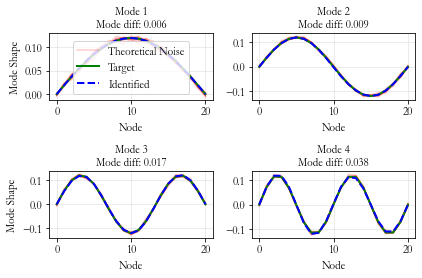

In [76]:
def generate_noisy_comparison(df, row_idx, n_samples=1):
    """Generate and compare theoretical noisy beam with actual data"""
    # Set font properties
    plt.rcParams.update({
        'font.family': 'Garamond',
        'font.size': 11,
        'axes.labelsize': 11,
        'axes.titlesize': 11,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11
    })
    
    row = df.iloc[row_idx]
    noise_level = row['noise_stddev']
    n_modes = len([col for col in df.columns if 'target_mode_' in col])
    
    # Calculate number of rows needed (2 plots per row)
    n_rows = (n_modes + 1) // 2
    
    fig = plt.figure(figsize=(6, 2*n_rows))
    gs = fig.add_gridspec(n_rows, 2)
    
    # Print information
    print("=== Noisy Beam Comparison ===")
    print(f"Noise Level (σ): {noise_level:.3f}")
    print(f"Damaged Element: {row['damaged_element']}")
    print(f"Damage Factor (Γ): {row['damage_factor']:.3f}")
    
    # Generate and plot noisy modes
    for i in range(n_modes):
        row_idx = i // 2
        col_idx = i % 2
        ax = fig.add_subplot(gs[row_idx, col_idx])
        
        target_mode = row[f'target_mode_{i+1}']
        identified_mode = row[f'identified_mode_{i+1}']
        
        # Calculate mean amplitude for noise scaling
        mean_amplitude = np.mean(np.abs(target_mode))
        noise_std = noise_level * mean_amplitude
        
        # Generate noisy samples
        x = np.arange(len(target_mode))
        noisy_samples = []
        for _ in range(n_samples):
            noise = np.random.normal(0, noise_std, size=target_mode.shape)
            noisy_mode = target_mode + noise
            noisy_samples.append(noisy_mode)
            ax.plot(x, noisy_mode, 'r-', alpha=0.2, label='Theoretical Noise' if _ == 0 else None)
        
        # Plot original and identified
        ax.plot(x, target_mode, 'g-', label='Target', linewidth=2)
        ax.plot(x, identified_mode, 'b--', label='Identified', linewidth=2)
        
        # Calculate and display metrics
        mode_diff = calculate_mode_diff(identified_mode, target_mode)
        ax.set_title(f'Mode {i+1}\nMode diff: {mode_diff:.3f}')
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend()
        ax.set_xlabel('Node')
        ax.set_ylabel('Mode Shape' if col_idx == 0 else '')
    
    plt.tight_layout()
    plt.show()

# Example usage with 10 noisy samples
generate_noisy_comparison(df, row_idx=6, n_samples=10)